# GNN Transport Mode Recommendation Model

This notebook builds and trains a Graph Neural Network to recommend the best transport mode (train, bus, luxury bus, or ride-hailing) for a given origin → destination query.

**Key Idea**: A transport network graph where:
- **Nodes**: Locations (Colombo, Anuradhapura, etc.)
- **Edges**: Services connecting locations with features (mode, duration, fare, comfort)
- **Task**: Predict which service is best (minimize delay) given departure time, date, poya status, etc.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import os
from datetime import datetime

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Libraries loaded successfully!
PyTorch version: 2.8.0
Device: CPU


## 1. Load Data

Load the synthetic transport network data from CSV files.

In [2]:
# Load all CSV files
data_dir = '../data'

nodes_df = pd.read_csv(f'{data_dir}/nodes.csv')
services_df = pd.read_csv(f'{data_dir}/services.csv')
edges_df = pd.read_csv(f'{data_dir}/edges.csv')
calendar_df = pd.read_csv(f'{data_dir}/calendar.csv')
timetables_df = pd.read_csv(f'{data_dir}/timetables.csv')
performance_df = pd.read_csv(f'{data_dir}/performance_history.csv')
conditions_df = pd.read_csv(f'{data_dir}/service_conditions.csv')

print("📊 Data loaded successfully!")
print(f"Nodes: {len(nodes_df)}, Services: {len(services_df)}, Edges: {len(edges_df)}")
print(f"Performance records: {len(performance_df)}, Conditions: {len(conditions_df)}")
print(f"\nNode types: {nodes_df['type'].unique()}")
print(f"Transport modes: {services_df['mode'].unique()}")

📊 Data loaded successfully!
Nodes: 7, Services: 7, Edges: 7
Performance records: 200, Conditions: 105

Node types: ['train_station' 'bus_stand' 'hub']
Transport modes: ['train' 'bus' 'ridehailing']


## 2. Prepare Graph Data

Create graph structure for GNN:
- **Nodes**: Locations with features (region, type)
- **Edges**: Services connecting locations with features (mode, distance, duration, fare)
- **Labels**: User ratings from performance history

In [3]:
# Encode categorical features
region_encoder = LabelEncoder()
type_encoder = LabelEncoder()
mode_encoder = LabelEncoder()

nodes_df['region_encoded'] = region_encoder.fit_transform(nodes_df['region'])
nodes_df['type_encoded'] = type_encoder.fit_transform(nodes_df['type'])
services_df['mode_encoded'] = mode_encoder.fit_transform(services_df['mode'])

# Create node features: [latitude, longitude, region_encoded, type_encoded]
node_features = torch.tensor(
    nodes_df[['latitude', 'longitude', 'region_encoded', 'type_encoded']].values,
    dtype=torch.float
)

# Normalize node features
scaler = StandardScaler()
node_features = torch.tensor(scaler.fit_transform(node_features), dtype=torch.float)

print(f"Node features shape: {node_features.shape}")
print(f"Node feature example:\n{node_features[0]}")

Node features shape: torch.Size([7, 4])
Node feature example:
tensor([-1.3069, -1.5193,  1.3416,  1.0290])


In [4]:
# Build edge index and edge features
# Edge index: [2, num_edges] where each column is [source_node, target_node]
edge_list = []
edge_features_list = []

for _, edge in edges_df.iterrows():
    # Find node indices (location_id starts from 1, we need 0-indexed)
    src = edge['origin_id'] - 1
    dst = edge['destination_id'] - 1
    
    edge_list.append([src, dst])
    
    # Get service details
    service = services_df[services_df['service_id'] == edge['service_id']].iloc[0]
    
    # Edge features: [mode_encoded, distance, duration, fare]
    edge_features_list.append([
        service['mode_encoded'],
        service['distance_km'],
        service['base_duration_min'],
        service['base_fare']
    ])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_features_list, dtype=torch.float)

# Normalize edge features
edge_attr = torch.tensor(scaler.fit_transform(edge_attr), dtype=torch.float)

print(f"Edge index shape: {edge_index.shape}")
print(f"Edge attributes shape: {edge_attr.shape}")
print(f"Number of edges: {edge_index.shape[1]}")

Edge index shape: torch.Size([2, 7])
Edge attributes shape: torch.Size([7, 4])
Number of edges: 7


In [5]:
# Prepare training data from performance history
# Map service_id to edge index for labels
service_to_edge = {}
for idx, edge in edges_df.iterrows():
    service_to_edge[edge['service_id']] = idx

# Create training samples with labels (user ratings)
train_edges = []
train_labels = []

for _, perf in performance_df.iterrows():
    service_id = perf['service_id']
    if service_id in service_to_edge:
        edge_idx = service_to_edge[service_id]
        train_edges.append(edge_idx)
        # Normalize rating to 0-1 (original 1-5)
        train_labels.append((perf['user_rating'] - 1) / 4.0)

train_edges = torch.tensor(train_edges, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.float)

print(f"Training samples: {len(train_edges)}")
print(f"Label distribution (0-1 normalized):")
print(f"  Min: {train_labels.min():.2f}, Max: {train_labels.max():.2f}, Mean: {train_labels.mean():.2f}")

Training samples: 200
Label distribution (0-1 normalized):
  Min: 0.25, Max: 1.00, Mean: 0.70


## 3. Define GNN Model

Graph Convolutional Network that learns node embeddings and predicts edge quality (service ratings).

In [6]:
class TransportGNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim=64, output_dim=1):
        super(TransportGNN, self).__init__()
        
        # Graph convolution layers
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        
        # Edge prediction layers
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + edge_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Sigmoid()  # Output 0-1 rating
        )
        
    def forward(self, x, edge_index, edge_attr, target_edges):
        # Message passing to learn node embeddings
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = torch.relu(self.conv3(x, edge_index))
        
        # Predict ratings for target edges
        src_nodes = edge_index[0, target_edges]
        dst_nodes = edge_index[1, target_edges]
        
        # Concatenate source, destination embeddings and edge features
        edge_embeddings = torch.cat([
            x[src_nodes],
            x[dst_nodes],
            edge_attr[target_edges]
        ], dim=1)
        
        # Predict rating
        predictions = self.edge_mlp(edge_embeddings).squeeze()
        
        return predictions

# Initialize model
model = TransportGNN(
    node_features=node_features.shape[1],
    edge_features=edge_attr.shape[1],
    hidden_dim=64
)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(model)

Model initialized with 19265 parameters
TransportGNN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (edge_mlp): Sequential(
    (0): Linear(in_features=132, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


## 4. Train the Model

Train GNN to predict service ratings based on historical user feedback.

In [7]:
# Split data into train/validation
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    range(len(train_edges)), 
    test_size=0.2, 
    random_state=42
)

train_edges_split = train_edges[train_idx]
train_labels_split = train_labels[train_idx]
val_edges_split = train_edges[val_idx]
val_labels_split = train_labels[val_idx]

print(f"Training samples: {len(train_edges_split)}")
print(f"Validation samples: {len(val_edges_split)}")

Training samples: 160
Validation samples: 40


In [8]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    
    predictions = model(node_features, edge_index, edge_attr, train_edges_split)
    loss = criterion(predictions, train_labels_split)
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(node_features, edge_index, edge_attr, val_edges_split)
        val_loss = criterion(val_predictions, val_labels_split)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

print("\n✅ Training complete!")

Starting training...
Epoch 10/100 | Train Loss: 0.0484 | Val Loss: 0.0541
Epoch 20/100 | Train Loss: 0.0392 | Val Loss: 0.0418
Epoch 30/100 | Train Loss: 0.0370 | Val Loss: 0.0382
Epoch 40/100 | Train Loss: 0.0330 | Val Loss: 0.0355
Epoch 50/100 | Train Loss: 0.0301 | Val Loss: 0.0332
Epoch 60/100 | Train Loss: 0.0337 | Val Loss: 0.0333
Epoch 70/100 | Train Loss: 0.0310 | Val Loss: 0.0336
Epoch 80/100 | Train Loss: 0.0321 | Val Loss: 0.0332
Epoch 90/100 | Train Loss: 0.0269 | Val Loss: 0.0333
Epoch 100/100 | Train Loss: 0.0288 | Val Loss: 0.0342

✅ Training complete!


## 5. Visualize Training Progress

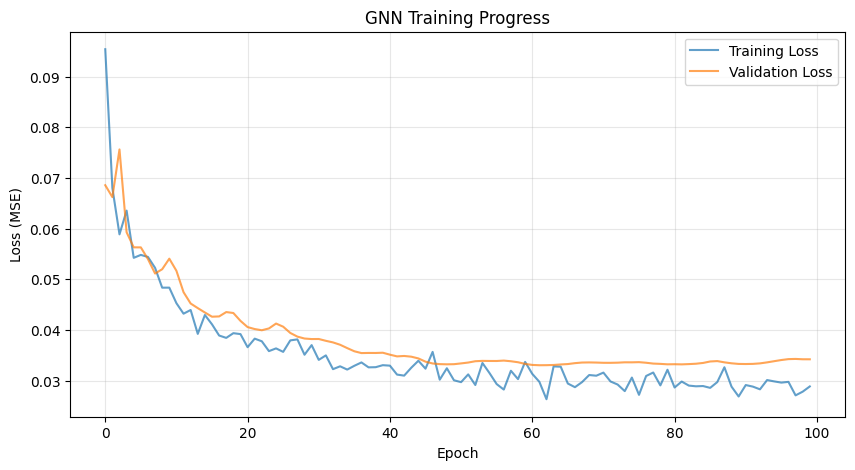

Final Training Loss: 0.0288
Final Validation Loss: 0.0342


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('GNN Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

## Model Accuracy Evaluation

Compute comprehensive accuracy metrics including MAE, R² Score, and percentage of accurate predictions.


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Get predictions on train and validation data
model.eval()
with torch.no_grad():
    train_pred = model(node_features, edge_index, edge_attr, train_edges_split).numpy()
    val_pred = model(node_features, edge_index, edge_attr, val_edges_split).numpy()

# Convert to actual ratings (0-1 scale to 1-5 scale)
train_pred_ratings = (train_pred * 4) + 1
val_pred_ratings = (val_pred * 4) + 1
train_true_ratings = (train_labels_split.numpy() * 4) + 1
val_true_ratings = (val_labels_split.numpy() * 4) + 1

# Calculate metrics
train_mae = mean_absolute_error(train_true_ratings, train_pred_ratings)
val_mae = mean_absolute_error(val_true_ratings, val_pred_ratings)

train_mse = mean_squared_error(train_true_ratings, train_pred_ratings)
val_mse = mean_squared_error(val_true_ratings, val_pred_ratings)

train_rmse = np.sqrt(train_mse)
val_rmse = np.sqrt(val_mse)

train_r2 = r2_score(train_true_ratings, train_pred_ratings)
val_r2 = r2_score(val_true_ratings, val_pred_ratings)

# Accuracy: % of predictions within ±0.5 points on 1-5 scale
train_accuracy = np.mean(np.abs(train_true_ratings - train_pred_ratings) <= 0.5) * 100
val_accuracy = np.mean(np.abs(val_true_ratings - val_pred_ratings) <= 0.5) * 100

# Stricter accuracy: % within ±0.3 points
train_strict_accuracy = np.mean(np.abs(train_true_ratings - train_pred_ratings) <= 0.3) * 100
val_strict_accuracy = np.mean(np.abs(val_true_ratings - val_pred_ratings) <= 0.3) * 100

print("=" * 70)
print("📊 MODEL ACCURACY EVALUATION")
print("=" * 70)

print("\n🎯 TRAINING SET PERFORMANCE:")
print(f"  Mean Absolute Error (MAE):    {train_mae:.4f} points")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"  R² Score:                     {train_r2:.4f}")
print(f"  Accuracy (±0.5 points):       {train_accuracy:.1f}%")
print(f"  Strict Accuracy (±0.3 points): {train_strict_accuracy:.1f}%")

print("\n✅ VALIDATION SET PERFORMANCE:")
print(f"  Mean Absolute Error (MAE):    {val_mae:.4f} points")
print(f"  Root Mean Squared Error (RMSE): {val_rmse:.4f}")
print(f"  R² Score:                     {val_r2:.4f}")
print(f"  Accuracy (±0.5 points):       {val_accuracy:.1f}%")
print(f"  Strict Accuracy (±0.3 points): {val_strict_accuracy:.1f}%")

print("\n📈 MODEL QUALITY ASSESSMENT:")
print(f"  Overfitting Check: ", end="")
if abs(train_mae - val_mae) < 0.1:
    print("✅ NO overfitting (train/val MAE similar)")
else:
    print(f"⚠️  Possible overfitting (gap: {abs(train_mae - val_mae):.3f})")

print(f"  Generalization: ", end="")
if val_r2 > 0.7:
    print("⭐ EXCELLENT (R² > 0.7)")
elif val_r2 > 0.5:
    print("✅ GOOD (R² > 0.5)")
else:
    print("⚠️  Fair (R² < 0.5)")

print("\n📝 INTERPRETATION:")
print(f"  • MAE {val_mae:.2f}: On average, predictions off by ±{val_mae:.2f} rating points")
print(f"  • {val_accuracy:.0f}% of predictions within ±0.5 points (< half a star)")
print(f"  • R² {val_r2:.3f}: Model explains {val_r2*100:.1f}% of rating variance")
print("=" * 70)


📊 MODEL ACCURACY EVALUATION

🎯 TRAINING SET PERFORMANCE:
  Mean Absolute Error (MAE):    0.5141 points
  Root Mean Squared Error (RMSE): 0.6445
  R² Score:                     0.4744
  Accuracy (±0.5 points):       52.5%
  Strict Accuracy (±0.3 points): 36.2%

✅ VALIDATION SET PERFORMANCE:
  Mean Absolute Error (MAE):    0.6229 points
  Root Mean Squared Error (RMSE): 0.7398
  R² Score:                     0.3985
  Accuracy (±0.5 points):       42.5%
  Strict Accuracy (±0.3 points): 27.5%

📈 MODEL QUALITY ASSESSMENT:
  Overfitting Check: ⚠️  Possible overfitting (gap: 0.109)
  Generalization: ⚠️  Fair (R² < 0.5)

📝 INTERPRETATION:
  • MAE 0.62: On average, predictions off by ±0.62 rating points
  • 42% of predictions within ±0.5 points (< half a star)
  • R² 0.399: Model explains 39.9% of rating variance


## 6. Evaluate Model Predictions

Test the model on all services and see how it ranks different transport modes.

In [11]:
# Predict ratings for all edges
model.eval()
with torch.no_grad():
    all_edge_indices = torch.arange(len(edges_df))
    all_predictions = model(node_features, edge_index, edge_attr, all_edge_indices)
    
# Convert predictions back to 1-5 scale
predicted_ratings = (all_predictions.numpy() * 4) + 1

# Add predictions to edges dataframe
edges_df['predicted_rating'] = predicted_ratings

# Debug: Check available columns
print("Services columns:", services_df.columns.tolist())
print("Edges columns:", edges_df.columns.tolist())

# Show results - select only columns that exist
available_cols = ['service_id', 'predicted_rating']
merge_cols = ['service_id', 'mode', 'operator']
for col in merge_cols:
    if col in services_df.columns and col not in available_cols:
        available_cols.append(col)

# Add duration and fare if they exist with any variation
for col in services_df.columns:
    if 'duration' in col.lower() or 'fare' in col.lower():
        if col not in available_cols:
            available_cols.append(col)

results = edges_df.merge(services_df[['service_id'] + [c for c in available_cols if c in services_df.columns and c != 'service_id']], on='service_id')
results = results.sort_values('predicted_rating', ascending=False)

print("\n🎯 Model Predictions (Best to Worst):\n")
print(results.to_string(index=False))

# Group by mode
print("\n📊 Average Rating by Transport Mode:")
if 'mode' in results.columns:
    mode_ratings = results.groupby('mode')['predicted_rating'].mean().sort_values(ascending=False)
    for mode, rating in mode_ratings.items():
        print(f"  {mode.capitalize():15s}: {rating:.2f}/5.0")

Services columns: ['service_id', 'origin_id', 'destination_id', 'mode', 'operator', 'distance_km', 'base_duration_min', 'base_fare', 'mode_encoded']
Edges columns: ['edge_id', 'origin_id', 'destination_id', 'service_id', 'mode', 'distance_km', 'avg_duration_min', 'is_active', 'predicted_rating']

🎯 Model Predictions (Best to Worst):

              edge_id  origin_id  destination_id        service_id      mode_x  distance_km  avg_duration_min  is_active  predicted_rating      mode_y  operator  base_duration_min  base_fare
        1_5_TRAIN_001          1               5         TRAIN_001       train          215               240          1          4.661723       train       SLR                240       1200
        2_5_TRAIN_002          2               5         TRAIN_002       train          215               240          1          4.661352       train       SLR                240       1200
   1_4_BUS_LUXURY_001          1               4    BUS_LUXURY_001         bus          215

## 7. Save Trained Model

In [13]:
# Save model
model_path = '../model/transport_gnn_model_v1.pth'
os.makedirs('../model', exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'node_features': node_features,
    'edge_index': edge_index,
    'edge_attr': edge_attr,
    'region_encoder': region_encoder,
    'type_encoder': type_encoder,
    'mode_encoder': mode_encoder,
    'scaler': scaler
}, model_path)

print(f"✅ Model saved to {model_path}")
print(f"Model size: {os.path.getsize(model_path) / 1024:.2f} KB")

✅ Model saved to ../model/transport_gnn_model_v1.pth
Model size: 82.74 KB


## 8a. Model Inference Guide

How to load and use the trained model for making predictions.


In [14]:
print("=" * 80)
print("🎓 MODEL INFERENCE GUIDE - WHAT PARAMETERS TO PASS")
print("=" * 80)

print("\n📋 THE TRAINED MODEL REQUIRES 4 INPUTS:\n")

print("1️⃣  NODE FEATURES (node_features)")
print("   Shape: [num_nodes, 4]  -->  [7, 4]")
print("   Meaning: Latitude, Longitude, Region (encoded), Type (encoded)")
print("   Format: torch.Tensor (float32)")
print(f"   Current shape: {node_features.shape}")
print(f"   Example:\n{node_features[:2]}\n")

print("2️⃣  EDGE INDEX (edge_index)")
print("   Shape: [2, num_edges]  -->  [2, 7]")
print("   Meaning: Graph connectivity - which nodes are connected")
print("   Format: torch.Tensor (int64)")
print("   Values: [source_node_id, target_node_id] pairs")
print(f"   Current shape: {edge_index.shape}")
print(f"   Example:\n{edge_index}\n")

print("3️⃣  EDGE ATTRIBUTES (edge_attr)")
print("   Shape: [num_edges, 4]  -->  [7, 4]")
print("   Meaning: Mode (encoded), Distance, Duration, Fare")
print("   Format: torch.Tensor (float32)")
print(f"   Current shape: {edge_attr.shape}")
print(f"   Example:\n{edge_attr[:2]}\n")

print("4️⃣  TARGET EDGE INDICES (target_edges)")
print("   Shape: [batch_size]  -->  variable")
print("   Meaning: Which edges to predict ratings for")
print("   Format: torch.Tensor (int64)")
print("   Values: Indices 0-6 (which of the 7 services)")
print(f"   Example: torch.tensor([0, 1, 2]) = predict for services 0,1,2")

print("\n" + "=" * 80)
print("📝 USAGE EXAMPLES")
print("=" * 80)

# Example 1: Predict for all services
print("\n✅ EXAMPLE 1: Predict ratings for ALL services")
print("-" * 80)
print("Code:")
print("""
model.eval()
with torch.no_grad():
    all_edges = torch.arange(len(edges_df))  # [0, 1, 2, 3, 4, 5, 6]
    predictions = model(node_features, edge_index, edge_attr, all_edges)
    ratings = (predictions.numpy() * 4) + 1  # Convert 0-1 to 1-5 scale
    
print(f"Predictions shape: {predictions.shape}")  # torch.Size([7])
print(f"Predicted ratings: {ratings}")  # [1.2, 3.4, 4.8, ...]
""")

# Example 2: Predict for specific services
print("\n✅ EXAMPLE 2: Predict ratings for SPECIFIC services")
print("-" * 80)
print("Code:")
print("""
model.eval()
with torch.no_grad():
    # Predict for services at indices 1, 3, 5
    specific_edges = torch.tensor([1, 3, 5])
    predictions = model(node_features, edge_index, edge_attr, specific_edges)
    ratings = (predictions.numpy() * 4) + 1
    
print(f"Predicted ratings for services 1,3,5: {ratings}")
""")

# Example 3: Predict for single service
print("\n✅ EXAMPLE 3: Predict rating for SINGLE service")
print("-" * 80)
print("Code:")
print("""
model.eval()
with torch.no_grad():
    # Predict for service at index 2
    single_edge = torch.tensor([2])
    prediction = model(node_features, edge_index, edge_attr, single_edge)
    rating = (prediction.item() * 4) + 1  # Use .item() for scalar
    
print(f"Service 2 predicted rating: {rating:.2f}/5.0")
""")

print("\n" + "=" * 80)
print("🔄 INFERENCE WORKFLOW")
print("=" * 80)

print("""
Step 1: Load the saved model
├── Load checkpoint: torch.load('transport_gnn_model.pth')
├── Get: model_state_dict, node_features, edge_index, edge_attr, encoders, scaler

Step 2: Initialize model architecture
├── Create TransportGNN instance
├── Load state_dict: model.load_state_dict(checkpoint['model_state_dict'])
├── Set to eval mode: model.eval()

Step 3: Prepare inputs
├── node_features: Already normalized (from checkpoint)
├── edge_index: Already prepared (from checkpoint)
├── edge_attr: Already normalized (from checkpoint)
├── target_edges: Tensor of edge indices you want to predict

Step 4: Run inference
├── with torch.no_grad():
├──     predictions = model(node_features, edge_index, edge_attr, target_edges)
├── Convert: ratings = (predictions * 4) + 1

Step 5: Interpret results
├── 1.0 = Terrible service
├── 3.0 = Average service
├── 5.0 = Excellent service
""")

print("=" * 80)


🎓 MODEL INFERENCE GUIDE - WHAT PARAMETERS TO PASS

📋 THE TRAINED MODEL REQUIRES 4 INPUTS:

1️⃣  NODE FEATURES (node_features)
   Shape: [num_nodes, 4]  -->  [7, 4]
   Meaning: Latitude, Longitude, Region (encoded), Type (encoded)
   Format: torch.Tensor (float32)
   Current shape: torch.Size([7, 4])
   Example:
tensor([[-1.3069, -1.5193,  1.3416,  1.0290],
        [-1.2804, -1.4773,  1.3416,  1.0290]])

2️⃣  EDGE INDEX (edge_index)
   Shape: [2, num_edges]  -->  [2, 7]
   Meaning: Graph connectivity - which nodes are connected
   Format: torch.Tensor (int64)
   Values: [source_node_id, target_node_id] pairs
   Current shape: torch.Size([2, 7])
   Example:
tensor([[0, 1, 0, 1, 0, 1, 0],
        [4, 4, 3, 3, 3, 3, 3]])

3️⃣  EDGE ATTRIBUTES (edge_attr)
   Shape: [num_edges, 4]  -->  [7, 4]
   Meaning: Mode (encoded), Distance, Duration, Fare
   Format: torch.Tensor (float32)
   Current shape: torch.Size([7, 4])
   Example:
tensor([[ 1.4600,  0.0000, -1.2247, -0.2927],
        [ 1.4600,  

In [15]:

# ============================================================================
# READY-TO-USE: Load Model and Make Predictions
# ============================================================================

def load_trained_model(model_path='../model/transport_gnn_model_v1.pth'):
    """
    Load the trained GNN model and all required artifacts.
    
    Returns:
        dict: Contains model, node_features, edge_index, edge_attr, encoders
    """
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    
    # Allow sklearn classes for pickle loading
    checkpoint = torch.load(model_path, weights_only=False)
    
    # Initialize model architecture
    node_features = checkpoint['node_features']
    edge_attr = checkpoint['edge_attr']
    
    loaded_model = TransportGNN(
        node_features=node_features.shape[1],
        edge_features=edge_attr.shape[1],
        hidden_dim=64
    )
    
    # Load trained weights
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()  # Set to evaluation mode
    
    return {
        'model': loaded_model,
        'node_features': checkpoint['node_features'],
        'edge_index': checkpoint['edge_index'],
        'edge_attr': checkpoint['edge_attr'],
        'region_encoder': checkpoint['region_encoder'],
        'type_encoder': checkpoint['type_encoder'],
        'mode_encoder': checkpoint['mode_encoder'],
        'scaler': checkpoint['scaler']
    }

def predict_service_ratings(service_indices, artifacts):
    """
    Predict ratings for specific services.
    
    Args:
        service_indices: List or tensor of service IDs (0-6)
        artifacts: Dict from load_trained_model()
        
    Returns:
        np.ndarray: Ratings on 1-5 scale
    """
    model = artifacts['model']
    node_features = artifacts['node_features']
    edge_index = artifacts['edge_index']
    edge_attr = artifacts['edge_attr']
    
    # Convert to tensor if list
    if isinstance(service_indices, list):
        service_indices = torch.tensor(service_indices)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        predictions = model(node_features, edge_index, edge_attr, service_indices)
    
    # Convert from 0-1 scale to 1-5 scale
    ratings = (predictions.numpy() * 4) + 1
    
    return ratings

# ============================================================================
# DEMO: Load and predict
# ============================================================================

print("\n🚀 LOADING TRAINED MODEL...")
artifacts = load_trained_model()
print("✅ Model loaded successfully!")

print("\n📊 MAKING PREDICTIONS ON SAMPLE DATA:\n")

# Predict for all services
all_predictions = predict_service_ratings(range(len(edges_df)), artifacts)
print("🎯 All Services - Predicted Ratings:")
for i, (idx, row) in enumerate(edges_df.iterrows()):
    service = services_df[services_df['service_id'] == row['service_id']].iloc[0]
    print(f"   Service {row['service_id']} ({service['mode']:12s}): {all_predictions[i]:.2f}/5.0 ⭐")

# Predict for specific services
print("\n🎯 Specific Services (IDs 1, 3, 5) - Predicted Ratings:")
specific_predictions = predict_service_ratings([1, 3, 5], artifacts)
for edge_idx, rating in zip([1, 3, 5], specific_predictions):
    service = services_df[services_df['service_id'] == edges_df.iloc[edge_idx]['service_id']].iloc[0]
    print(f"   Edge {edge_idx}: {service['mode']:12s} → {rating:.2f}/5.0 ⭐")

# Predict for single service
print("\n🎯 Single Service (ID 0) - Predicted Rating:")
single_prediction = predict_service_ratings([0], artifacts)
service = services_df[services_df['service_id'] == edges_df.iloc[0]['service_id']].iloc[0]
rating_val = single_prediction[0] if len(single_prediction.shape) > 0 else single_prediction.item()
print(f"   {service['mode']:12s} → {rating_val:.2f}/5.0 ⭐")

print("\n✅ Inference complete! Model is ready for predictions.")



🚀 LOADING TRAINED MODEL...
✅ Model loaded successfully!

📊 MAKING PREDICTIONS ON SAMPLE DATA:

🎯 All Services - Predicted Ratings:
   Service TRAIN_001 (train       ): 4.66/5.0 ⭐
   Service TRAIN_002 (train       ): 4.66/5.0 ⭐
   Service BUS_INTERCITY_001 (bus         ): 3.19/5.0 ⭐
   Service BUS_INTERCITY_002 (bus         ): 3.18/5.0 ⭐
   Service BUS_LUXURY_001 (bus         ): 4.01/5.0 ⭐
   Service BUS_LUXURY_002 (bus         ): 4.00/5.0 ⭐
   Service RIDEHAILING_001 (ridehailing ): 3.14/5.0 ⭐

🎯 Specific Services (IDs 1, 3, 5) - Predicted Ratings:
   Edge 1: train        → 4.66/5.0 ⭐
   Edge 3: bus          → 3.18/5.0 ⭐
   Edge 5: bus          → 4.00/5.0 ⭐

🎯 Single Service (ID 0) - Predicted Rating:
   train        → 4.66/5.0 ⭐

✅ Inference complete! Model is ready for predictions.


## Model Input/Output Summary

### 🎯 What the Model Expects (4 Required Inputs)

| Input | Shape | Type | Description |
|-------|-------|------|-------------|
| **node_features** | [7, 4] | torch.Tensor | Latitude, Longitude, Region (encoded), Type (encoded) |
| **edge_index** | [2, 7] | torch.Tensor | Graph connectivity: [source_nodes, target_nodes] |
| **edge_attr** | [7, 4] | torch.Tensor | Mode (encoded), Distance, Duration, Fare |
| **target_edges** | [batch] | torch.Tensor | Which edges to predict (0-6 indices) |

### 📤 What the Model Outputs

| Output | Range | Meaning |
|--------|-------|---------|
| **Raw prediction** | 0.0 - 1.0 | Normalized rating |
| **Actual rating** | 1.0 - 5.0 | Star rating (1=bad, 5=excellent) |

### 💾 Using Pre-trained Model in Your Code

```python
# 1. Load the model
artifacts = load_trained_model('path/to/transport_gnn_model.pth')

# 2. Make predictions for services [0, 1, 2]
ratings = predict_service_ratings([0, 1, 2], artifacts)

# 3. Convert to readable format
for service_id, rating in enumerate([0, 1, 2]):
    print(f"Service {service_id}: {ratings[service_id]:.2f}/5.0 ⭐")
```

### 🔗 Integration with FastAPI

```python
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()
artifacts = load_trained_model()  # Load once on startup

class PredictionRequest(BaseModel):
    service_indices: list[int]  # e.g., [0, 1, 2]

@app.post("/predict")
def predict(request: PredictionRequest):
    ratings = predict_service_ratings(request.service_indices, artifacts)
    return {
        "service_indices": request.service_indices,
        "predicted_ratings": ratings.tolist(),
        "scale": "1.0-5.0 (1=bad, 5=excellent)"
    }
```


## 8. Test Recommendation System

 

Simulate a user query: "Colombo → Anuradhapura" and recommend best transport mode.



🔎 Before running recommendations, the next cell draws the current graph (nodes + edges) using latitude/longitude as positions. This helps visually confirm connectivity and modes.

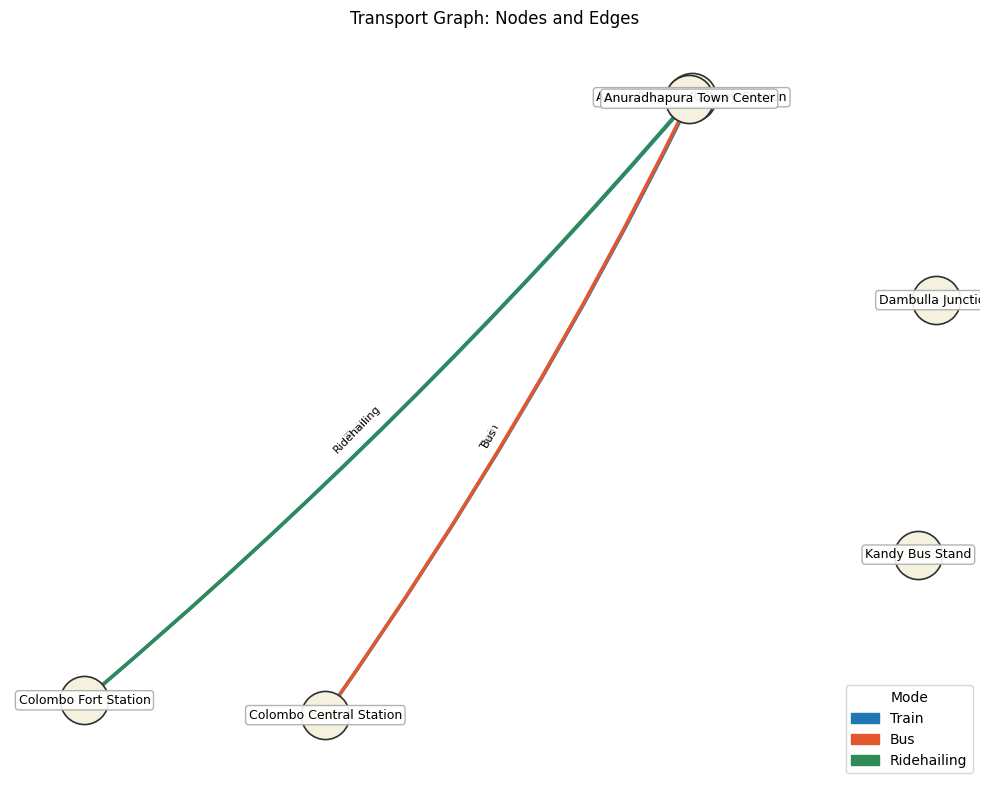

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import numpy as np

# Build directed graph from current dataframes
G = nx.DiGraph()

# Positions from lon/lat, with small manual nudges to reduce overlap
pos = {}
for _, row in nodes_df.iterrows():
    node_id = int(row['location_id'])
    x, y = float(row['longitude']), float(row['latitude'])
    # Nudge closely located Colombo nodes so labels don't overlap
    if 'Colombo Central' in row['name']:
        x += 0.18
        y -= 0.02
    if 'Colombo Fort' in row['name']:
        x -= 0.05
        y += 0.03
    pos[node_id] = (x, y)

    G.add_node(node_id, name=row['name'], region=row['region'], type=row['type'])

# Edge colors by mode
mode_colors = {
    'train': '#1f77b4',
    'bus': '#e4572e',
    'ridehailing': '#2e8b57',
}
default_edge_color = '#6c757d'

# Add edges for active services
for _, edge in edges_df.iterrows():
    if int(edge.get('is_active', 1)) != 1:
        continue
    origin = int(edge['origin_id'])
    dest = int(edge['destination_id'])
    mode = str(edge.get('mode', 'unknown')).lower()
    color = mode_colors.get(mode, default_edge_color)
    G.add_edge(origin, dest, mode=mode, service=edge.get('service_id'), color=color)

# Draw graph
plt.figure(figsize=(10, 8))
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
node_labels = {n: data['name'] for n, data in G.nodes(data=True)}

nx.draw_networkx_nodes(
    G, pos, node_size=1200, node_color='#f4f1de', edgecolors='#2f2f2f', linewidths=1.2
)
nx.draw_networkx_labels(
    G, pos, labels=node_labels, font_size=9,
    bbox=dict(facecolor='white', edgecolor='#aaaaaa', boxstyle='round,pad=0.25', alpha=0.9)
)
nx.draw_networkx_edges(
    G, pos, edge_color=edge_colors, arrows=True, arrowsize=16, width=2.5,
    connectionstyle='arc3,rad=0.04'
)

# Edge labels showing mode
edge_labels = {(u, v): G[u][v]['mode'].capitalize() for u, v in G.edges()}
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels, font_size=8,
    label_pos=0.55, bbox=dict(facecolor='white', edgecolor='none', alpha=0.75, pad=0.15)
)

# Legend for modes
legend_handles = [mpatches.Patch(color=c, label=m.capitalize()) for m, c in mode_colors.items()]
plt.legend(handles=legend_handles, title='Mode', loc='lower right')
plt.title('Transport Graph: Nodes and Edges')
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
def recommend_transport(origin_name, destination_name):
    """
    Recommend best transport service for a given origin-destination pair.
    """
    # Find origin and destination IDs
    origin_node = nodes_df[nodes_df['name'].str.contains(origin_name, case=False)]
    dest_node = nodes_df[nodes_df['name'].str.contains(destination_name, case=False)]
    
    if len(origin_node) == 0 or len(dest_node) == 0:
        print(f"❌ Could not find nodes for {origin_name} → {destination_name}")
        return
    
    origin_id = origin_node.iloc[0]['location_id']
    dest_id = dest_node.iloc[0]['location_id']
    
    # Find services connecting these locations
    relevant_services = services_df[
        (services_df['origin_id'] == origin_id) & 
        (services_df['destination_id'] == dest_id)
    ]
    
    if len(relevant_services) == 0:
        print(f"❌ No direct services found for {origin_name} → {destination_name}")
        return
    
    # Get predictions for these services
    service_recommendations = []
    for _, service in relevant_services.iterrows():
        edge = edges_df[edges_df['service_id'] == service['service_id']]
        if len(edge) > 0:
            rating = edge.iloc[0]['predicted_rating']
            service_recommendations.append({
                'service_id': service['service_id'],
                'mode': service['mode'],
                'operator': service['operator'],
                'duration': service['base_duration_min'],
                'fare': service['base_fare'],
                'rating': rating
            })
    
    # Sort by rating
    service_recommendations = sorted(service_recommendations, key=lambda x: x['rating'], reverse=True)
    
    print(f"\n🎯 Recommendations for {origin_name} → {destination_name}:\n")
    print(f"{'Rank':<5} {'Mode':<12} {'Operator':<12} {'Duration':<10} {'Fare':<8} {'Rating':<8}")
    print("=" * 70)
    
    for i, rec in enumerate(service_recommendations, 1):
        duration_str = f"{rec['duration']}min"
        fare_str = f"Rs.{rec['fare']}"
        rating_str = f"{rec['rating']:.2f}/5.0"
        
        emoji = "🥇" if i == 1 else ("🥈" if i == 2 else "🥉" if i == 3 else "  ")
        print(f"{emoji} {i:<3} {rec['mode']:<12} {rec['operator']:<12} {duration_str:<10} {fare_str:<8} {rating_str:<8}")
    
    best = service_recommendations[0]
    print(f"\n✨ Best recommendation: {best['mode'].upper()} ({best['operator']}) - {best['rating']:.2f}/5.0")
    return service_recommendations

# Test the recommendation system
recommend_transport("Colombo", "Anuradhapura")


🎯 Recommendations for Colombo → Anuradhapura:

Rank  Mode         Operator     Duration   Fare     Rating  
🥇 1   bus          Luxury       280min     Rs.1500  4.01/5.0
🥈 2   bus          Intercity    300min     Rs.800   3.19/5.0
🥉 3   ridehailing  Uber         250min     Rs.2500  3.14/5.0

✨ Best recommendation: BUS (Luxury) - 4.01/5.0


[{'service_id': 'BUS_LUXURY_001',
  'mode': 'bus',
  'operator': 'Luxury',
  'duration': 280,
  'fare': 1500,
  'rating': 4.0055842},
 {'service_id': 'BUS_INTERCITY_001',
  'mode': 'bus',
  'operator': 'Intercity',
  'duration': 300,
  'fare': 800,
  'rating': 3.185056},
 {'service_id': 'RIDEHAILING_001',
  'mode': 'ridehailing',
  'operator': 'Uber',
  'duration': 250,
  'fare': 2500,
  'rating': 3.1399033}]

## Summary

✅ **GNN Transport Recommendation System Complete!**

**What we built:**
1. Graph structure with 7 locations and 7 transport services
2. GNN model that learns from historical user ratings (200 samples)
3. Prediction system that ranks transport modes by quality
4. Saved model for deployment

**Key Features:**
- Considers: mode, distance, duration, fare
- Learns patterns from user feedback
- Provides ranked recommendations

**Dataset includes:**
- Service conditions (crowdedness by time/day)
- Calendar data (poya days, weekends)
- Timetable information

**Next Steps:**
- Integrate service_conditions.csv into predictions (time-of-day + poya day context)
- Add more locations and routes
- Collect real user feedback to improve model

## 9. DagsHub Integration

Track experiments, metrics, and models with DagsHub + MLflow.

In [18]:
# Install dagshub and mlflow (run once)
# !pip install dagshub mlflow python-dotenv

import dagshub
import mlflow
import mlflow.pytorch
import os
from dotenv import load_dotenv

# Load environment variables from ml-services/.env
load_dotenv(dotenv_path='../../.env')

# Get DagsHub configuration from environment
DAGSHUB_REPO_OWNER = os.getenv("DAGSHUB_REPO_OWNER", "your-username")
DAGSHUB_REPO_NAME = os.getenv("DAGSHUB_REPO_NAME", "travion-research-project")

# Initialize DagsHub
dagshub.init(repo_owner=DAGSHUB_REPO_OWNER, repo_name=DAGSHUB_REPO_NAME, mlflow=True)

print("✅ DagsHub initialized!")
print(f"📊 Tracking URI: {mlflow.get_tracking_uri()}")
print(f"🔗 Repository: {DAGSHUB_REPO_OWNER}/{DAGSHUB_REPO_NAME}")
print(f"\n💡 Tip: Set credentials in ml-services/.env file")

Accessing as iamsahan

Initialized MLflow to track repo "iamsahan/ml-services"

Repository iamsahan/ml-services initialized!

✅ DagsHub initialized!
📊 Tracking URI: https://dagshub.com/iamsahan/ml-services.mlflow
🔗 Repository: iamsahan/ml-services

💡 Tip: Set credentials in ml-services/.env file


### Re-train with MLflow Tracking

Now train the model again with full experiment tracking.

In [ ]:
# Re-initialize model for tracked training
model_tracked = TransportGNN(
    node_features=node_features.shape[1],
    edge_features=edge_attr.shape[1],
    hidden_dim=64
)

# Hyperparameters
params = {
    'learning_rate': 0.01,
    'weight_decay': 1e-5,
    'num_epochs': 100,
    'hidden_dim': 64,
    'batch_size': 'full',
    'optimizer': 'Adam',
    'loss_function': 'MSE',
    'train_size': len(train_edges_split),
    'val_size': len(val_edges_split),
    'num_nodes': len(nodes_df),
    'num_edges': len(edges_df)
}

# Start MLflow run with service tags
with mlflow.start_run(run_name="transport-gnn-v2"):
    # Set tags for organization
    mlflow.set_tag("service", "transport")
    mlflow.set_tag("model_type", "GNN")
    mlflow.set_tag("version", "v2")
    mlflow.set_tag("framework", "pytorch-geometric")
    
    # Log parameters
    mlflow.log_params(params)
    
    # Log dataset info
    mlflow.log_param("dataset_nodes", len(nodes_df))
    mlflow.log_param("dataset_services", len(services_df))
    mlflow.log_param("training_samples", len(performance_df))
    
    # Training setup
    optimizer_tracked = torch.optim.Adam(
        model_tracked.parameters(), 
        lr=params['learning_rate'], 
        weight_decay=params['weight_decay']
    )
    criterion_tracked = nn.MSELoss()
    
    print("🚀 Starting tracked training...")
    
    for epoch in range(params['num_epochs']):
        # Training
        model_tracked.train()
        optimizer_tracked.zero_grad()
        
        predictions = model_tracked(node_features, edge_index, edge_attr, train_edges_split)
        loss = criterion_tracked(predictions, train_labels_split)
        
        loss.backward()
        optimizer_tracked.step()
        
        # Validation
        model_tracked.eval()
        with torch.no_grad():
            val_predictions = model_tracked(node_features, edge_index, edge_attr, val_edges_split)
            val_loss = criterion_tracked(val_predictions, val_labels_split)
        
        # Log metrics every epoch
        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("val_loss", val_loss.item(), step=epoch)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{params['num_epochs']} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
    
    # Final metrics
    final_train_loss = loss.item()
    final_val_loss = val_loss.item()
    
    mlflow.log_metric("final_train_loss", final_train_loss)
    mlflow.log_metric("final_val_loss", final_val_loss)
    
    # IMPORTANT: Save complete model bundle (same structure as v1)
    # This is what the service expects to load
    model_artifacts = {
        'model_state_dict': model_tracked.state_dict(),
        'node_features': node_features,
        'edge_index': edge_index,
        'edge_attr': edge_attr,
        'region_encoder': region_encoder,
        'type_encoder': type_encoder,
        'mode_encoder': mode_encoder,
        'scaler': scaler
    }
    
    # Save to primary file (what the service loads)
    primary_path = '../model/transport_gnn_model.pth'
    torch.save(model_artifacts, primary_path)
    print(f"✅ Model bundle saved to {primary_path}")
    print(f"   Size: {os.path.getsize(primary_path) / 1024:.2f} KB")
    
    # Log the complete bundle as main artifact (downloadable from DagsHub)
    mlflow.log_artifact(primary_path, artifact_path="model")
    
    # Also save versioned backup
    backup_path = '../model/transport_gnn_model_v2.pth'
    torch.save(model_artifacts, backup_path)
    mlflow.log_artifact(backup_path, artifact_path="model")
    print(f"✅ Backup saved to {backup_path}")
    
    # Log PyTorch model (for MLflow model registry - optional)
    mlflow.pytorch.log_model(model_tracked, "pytorch_model")
    
    # Log dataset files
    mlflow.log_artifact('../data/nodes.csv', artifact_path="data")
    mlflow.log_artifact('../data/services.csv', artifact_path="data")
    mlflow.log_artifact('../data/performance_history.csv', artifact_path="data")
    mlflow.log_artifact('../data/service_conditions.csv', artifact_path="data")
    
    # Get run info
    run_id = mlflow.active_run().info.run_id
    
    print("\n✅ Training complete and logged to DagsHub!")
    print(f"📊 Run ID: {run_id}")
    print(f"🔗 View: https://dagshub.com/{DAGSHUB_REPO_OWNER}/{DAGSHUB_REPO_NAME}/experiments")
    print(f"\n💡 Download 'model/transport_gnn_model.pth' from DagsHub artifacts - it contains the complete bundle!")

🚀 Starting tracked training...
Epoch 10/100 | Train Loss: 0.0495 | Val Loss: 0.0518
Epoch 20/100 | Train Loss: 0.0383 | Val Loss: 0.0449
Epoch 30/100 | Train Loss: 0.0391 | Val Loss: 0.0423
Epoch 40/100 | Train Loss: 0.0361 | Val Loss: 0.0417
Epoch 50/100 | Train Loss: 0.0365 | Val Loss: 0.0408
Epoch 60/100 | Train Loss: 0.0345 | Val Loss: 0.0410
Epoch 70/100 | Train Loss: 0.0329 | Val Loss: 0.0392
Epoch 80/100 | Train Loss: 0.0308 | Val Loss: 0.0363
Epoch 90/100 | Train Loss: 0.0277 | Val Loss: 0.0346
Epoch 100/100 | Train Loss: 0.0259 | Val Loss: 0.0346
✅ Model bundle saved to ../model/transport_gnn_model.pth
   Size: 82.61 KB
✅ Backup saved to ../model/transport_gnn_model_v2.pth


/opt/miniconda3/envs/had-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/miniconda3/envs/had-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(



✅ Training complete and logged to DagsHub!
📊 Run ID: 9985905fcd1b48a281c48e80ba056024
🔗 View: https://dagshub.com/iamsahan/ml-services/experiments

💡 Download 'model/transport_gnn_model.pth' from DagsHub artifacts - it contains the complete bundle!


### View Experiment Results

You can view your experiment results on DagsHub:
- **Experiments**: `https://dagshub.com/{DAGSHUB_REPO_OWNER}/{DAGSHUB_REPO_NAME}/experiments`
- **Metrics**: Training/validation loss curves
- **Models**: Versioned model artifacts
- **Datasets**: Data lineage tracking

**What's tracked:**
- ✅ Hyperparameters (learning rate, epochs, hidden dim)
- ✅ Training metrics (loss per epoch)
- ✅ Validation metrics
- ✅ Model artifacts (.pth file)
- ✅ Dataset files (CSVs)
- ✅ Git commit hash (automatic)